# About
Here I want to explore different machine learning models for timeseries prediction. I use a real timeseries dataset that I found on [Kaggle](www.kaggle.com).

I worked on this while taking the [DeepLearning.AI course "Sequences, Time Series and Prediction"](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction).

## Concepts covered
* Univariate timeseries
* ARIMA model
* Neural networks
* MLP model
* Regularization (L2, drop-out)
* Hyperparameter tuning
* Convolutional layers
* Recurrent neural networks (RNN)
* LSTM (Long short-term Memory) models

## Tools used
* Tensorfow: `tf.data.Dataset`, `tf.keras.Sequential`
* Kaggle API
* Pandas

# Imports, setup

In [329]:
import numpy as np
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from kaggle.api.kaggle_api_extended import KaggleApi

import tensorflow as tf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from scipy.signal import periodogram

## Download data from Kaggle
In order to focus on model concepts rather than digging into a complex dataset, I pick a fairly well-studied dataset: [monthly sunspot activity](https://www.kaggle.com/robervalt/sunspots/activity), the most popular sunspot dataset on Kaggle. As the [data description page](https://www.kaggle.com/robervalt/sunspots) states,
sunspots are phenomena on the sun which vary with a approximately 11-year cycle. 

Note that this step requires using the [Kaggle API](https://github.com/Kaggle/kaggle-api) and authenticating using the API credentials. 

In [2]:
api = KaggleApi()
try:
    api.authenticate()
except Exception as e:
    print("Kaggle authentication failed!")
    raise e

sunspot_datasets = api.datasets_list(search='sunspots')
sunspot_datasets.sort(key=lambda d: (d['voteCount'], d['viewCount']), reverse=True)

for d in sunspot_datasets:
    # d is a dict
    print(f"\"{d['title']}\": \n\t votes: {d['voteCount']}; views: {d['viewCount']}; {d['url']}")

"Sunspots": 
	 votes: 84; views: 23743; https://www.kaggle.com/robervalt/sunspots
"Daily Sun Spot Data (1818 to 2019)": 
	 votes: 22; views: 4455; https://www.kaggle.com/abhinand05/daily-sun-spot-data-1818-to-2019
"climate change": 
	 votes: 15; views: 7542; https://www.kaggle.com/econdata/climate-change
"NASA and NOAA  Satellites Solar-Wind Dataset": 
	 votes: 8; views: 893; https://www.kaggle.com/arashnic/soalr-wind
"RiseInTemp_dataset": 
	 votes: 6; views: 2407; https://www.kaggle.com/vageeshabudanur/riseintemp-dataset
"Monthly Sunspots": 
	 votes: 0; views: 212; https://www.kaggle.com/hugoherrera11/monthly-sunspots
"Sunspots": 
	 votes: 0; views: 96; https://www.kaggle.com/parichatapi/sunspots
"pyspark-library": 
	 votes: 0; views: 79; https://www.kaggle.com/rhtsingh/pysparklibrary


In [3]:
ref="robervalt/sunspots" 
datafiles = api.dataset_list_files(ref).files
print(f"Files in dataset \"{ref}\": {datafiles}")

# Download and unzip dataset into current directory
api.dataset_download_files(ref, unzip=True)
csv_file = str(datafiles[0])
!ls {csv_file}

Files in dataset "robervalt/sunspots": [Sunspots.csv]
Sunspots.csv


The dataset is a basic univariate timeseries, just dates and monthly sunspot numbers:

In [4]:
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


## Data preprocess

In [5]:
df = df.drop(columns=df.columns[0]).rename(
    columns={df.columns[1]: 'date', df.columns[2]: 'sunspots'})
df.date = pd.to_datetime(df.date)
print(df.head())

        date  sunspots
0 1749-01-31      96.7
1 1749-02-28     104.3
2 1749-03-31     116.7
3 1749-04-30      92.8
4 1749-05-31     141.7


In [6]:
# Assert that the timestamp differences are monthly: either +1 month or -11 (new year, Jan-Dec)
print(set(df.date.dt.month.diff()[1:].unique()) == {1, -11})

True


## Helper functionality and variables

In [354]:
# Helper variables
num_times = len(df.sunspots)
print(num_times)

3265


In [532]:
def evaluate(y, yhat):
    mse = np.mean((y - yhat)**2)
    mae = np.mean(np.abs(y-yhat))
    return dict(mse=mse, mae=mae)

# Data exploration

## Statistics and distribution

Here is the variation of number of sunspots over time:

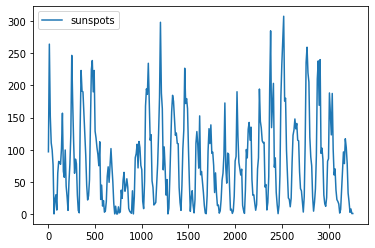

In [20]:
sns.lineplot(data=df[::10],);

These are some basic statistics:

In [1221]:
df.sunspots.describe()

count    3265.000000
mean       81.778775
std        67.889277
min         0.000000
25%        23.900000
50%        67.200000
75%       122.500000
max       398.200000
Name: sunspots, dtype: float64

And this is the distribution:

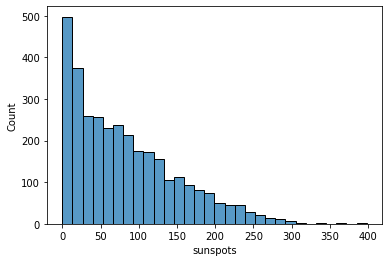

In [1220]:
sns.histplot(df.sunspots);

Clearly, there is a quite long tail at high values.
Generally, one would normalize the data here, using either min-max normalization

\begin{equation}
y' = \frac{y_i - y_\min}{y_{\max} - y_{\min}}
\end{equation}

or by using standardization (Z-score normalization):

\begin{equation}
y'_i = \frac{y - \mu_y}{\sigma_y}
\end{equation}
where $\mu_y$ and $\sigma_y$ are estiamtes of the mean and standard deviation of y, respectively.

Here, I skip this step for simplicity, keeping in mind that it will affect the values of of my loss function.

## Periodicity

We are already given the approximate periodicity of the sunspot data approximately, but this can be made more exact/verified by looking at the frequency distribution  of the calculated [power spectral density](https://en.wikipedia.org/wiki/Spectral_density) (known as a [periodogram](https://en.wikipedia.org/wiki/Periodogram)).

Period at max in months: 130.6 months = 10.883333333333333 years.
Left, right: 136.04166666666666, 125.57692307692308 months.


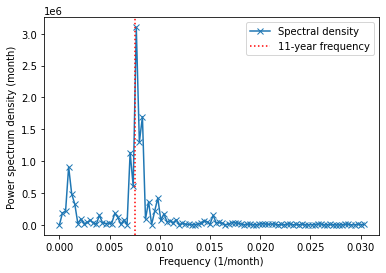

In [22]:
f, spec = periodogram(df.sunspots)

plt.plot(f[:100], spec[:100], 'x-', label='Spectral density')
plt.xlabel('Frequency (1/month)');
plt.ylabel("Power spectrum density (month)")

plt.axvline(x=1/(11*12), linestyle=':', color='red', label='11-year frequency')

plt.legend()
imax = np.argmax(spec)
left, center, right = 1/f[imax-1:imax+2] # years
print(f"Period at max in months: {center} months = {center/12} years.\nLeft, right: {left}, {right} months.")

The largest peak in the spectrum indeed corresponds to approximately 11 years but we see that there are also other relevant frequencies in the spectrum, such as the peak at very low frequencies, corresponding to ~91 years.

When applying differencing methods for the modeling, a more direct metric for determining the seasonality  is to look at the autocorrelation function, i.e. the correlations of data separated by a certain lag. The autocorrelation and the spectral density are similar in that they both quantify correlations over time, but different (the relationship between them is given by the [Wiener-Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem)).

2nd max autocorrelation value: [0.57929215 0.58087362 0.57577442]
Lag at 2nd max of autocorrelation: 128
Number of periods in dataset: 25.5078125


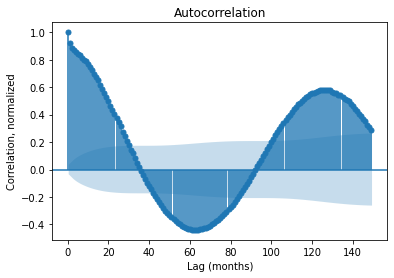

In [872]:
plot_acf(df.sunspots, lags=range(0,150));

acf_vals = acf(df.sunspots, nlags=150, fft=False)

# Find index of the second max
start = 60
period = np.argmax(acf_vals[start:]) + start
print("2nd max autocorrelation value:", acf_vals[period-1:period+2])
print("Lag at 2nd max of autocorrelation:", period)
print(f"Number of periods in dataset: {len(df)/period}")
plt.xlabel('Lag (months)')
plt.ylabel('Correlation, normalized');

The first peak corresponds to the variation at any given time, i.e. covariance. Here, the autocorrelation has been normalized by this value, so that the first peak has height 1. The second peak at a lag time of 128 months, or $\approx 10.67$ years, corresponds to the fact that an observation at any given time positively correlates with the observation 128 months later. We can use this period as input information to our modeling.

# Baseline model: ARIMA

In [647]:
def predict_ARIMA(x, times, model, model_fit):
    "Make predictions for trained model using data x"
    if isinstance(model, ARIMA):
        tmp_model = ARIMA(x, order=model.order, trend=model.trend, seasonal_order=model.seasonal_order)
    else:
        tmp_model = SARIMAX(x, order=model.order, trend=model.trend, seasonal_order=model.seasonal_order)

    tmp_fit = tmp_model.smooth(model_fit.params)
    yhat = tmp_fit.predict(times[0], times[-1])
    return yhat

In [874]:
16/25

0.64

## Some preliminary tests
ARIMA(0,1,0) is a very simple model that just predicts the value of the next month to be the same as the current month.
I use 16 128-month periods for training and the remaining for validation.

ARIMA model orders (0, 1, 0) (0, 0, 0, 128)
split: 2048, trend: None
{'mse': 692.6580197206245, 'mae': 18.875184880854558}


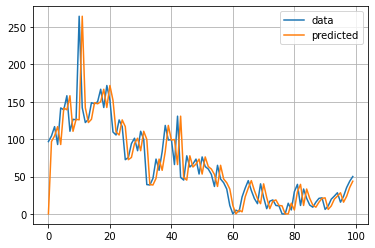

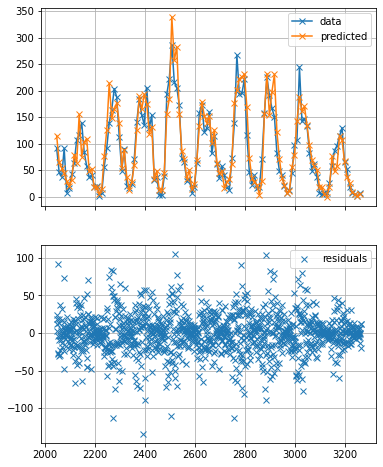

In [88]:
# Configuration
split = period*16
p, d, q = 0, 1, 0
P, D, Q, S = 0, 0, 0, period
seasonal_order = P, D, Q, S
order = (p, d, q)
trend = None if (d or D) else 'ct'
arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
print("ARIMA model orders", order, seasonal_order)    
print(f"split: {split}, trend: {trend}")

# Fit and predict
baseline = ARIMA(df.sunspots[:split], **arima_config)
baseline_fit = baseline.fit()
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), baseline, baseline_fit)

# plot
plt.grid()
plt.plot(df.sunspots[:100], label='data')
plt.plot(yhat[:100], label='predicted')
plt.legend()

fig, axes = plt.subplots(2,1, figsize=(6, 8), sharex=True)
ax = axes[0]
ax.grid()
ax.plot(df.sunspots[split::10], '-x', label='data')
ax.plot(yhat[split::10], '-x', label='predicted')
ax.legend()

ax = axes[1]
ax.grid()
res = yhat - df.sunspots
ax.plot(res[split:], 'x', label='residuals');
ax.legend()

# Print metrics
print(evaluate(df.sunspots[split:], yhat[split:]))

We see that already this model is doing pretty good in forecasting the next step. But there are still large residual values, seemingly periodically occurring. I try to see if adding seasonal differencing terms help, but it actually significantly decreases the performance of the model:

ARIMA model orders (0, 1, 0) (0, 1, 0, 128)
split: 2048, trend: None
{'mse': 1279.279745275281, 'mae': 25.886359901396993}


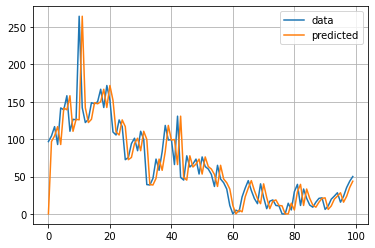

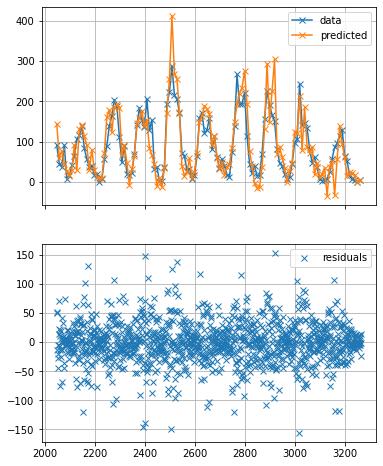

In [89]:
# Configuration
split = period*16
p, d, q = 0, 1, 0
P, D, Q, S = 0, 1, 0, period
seasonal_order = P, D, Q, S
order = (p, d, q)
trend = None if (d or D) else 'ct'
arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
print("ARIMA model orders", order, seasonal_order)    
print(f"split: {split}, trend: {trend}")

# Fit and predict
baseline = SARIMAX(df.sunspots[:split], **arima_config)
baseline_fit = baseline.fit()
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), baseline, baseline_fit)

# plot
plt.grid()
plt.plot(df.sunspots[:100], label='data')
plt.plot(yhat[:100], label='predicted')
plt.legend()

fig, axes = plt.subplots(2,1, figsize=(6, 8), sharex=True)
ax = axes[0]
ax.grid()
ax.plot(df.sunspots[split::10], '-x', label='data')
ax.plot(yhat[split::10], '-x', label='predicted')
ax.legend()

ax = axes[1]
ax.grid()
res = yhat - df.sunspots
ax.plot(res[split:], 'x', label='residuals');
ax.legend()

# Print metrics
print(evaluate(df.sunspots[split:], yhat[split:]))

I also test adding an seasonal MA(1) term to see if that helps the seasonal ARIMA model compete with the naiva ARIMA(0,1,0) model:

ARIMA model orders (0, 1, 0) (0, 1, 1, 128)
split: 2048, trend: None
{'mse': 725.7241883005468, 'mae': 19.587603019185867}


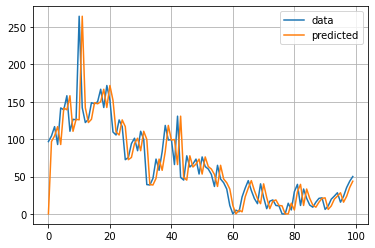

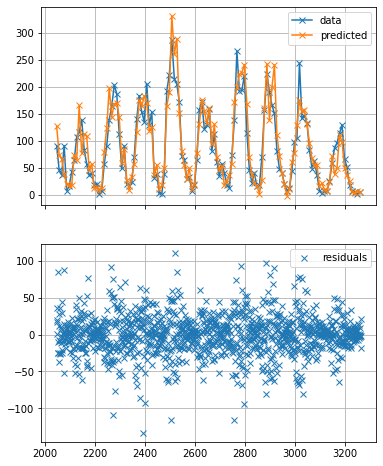

In [90]:
# Configuration
split = period*16
p, d, q = 0, 1, 0
P, D, Q, S = 0, 1, 1, period
seasonal_order = P, D, Q, S
order = (p, d, q)
trend = None if (d or D) else 'ct'
arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
print("ARIMA model orders", order, seasonal_order)    
print(f"split: {split}, trend: {trend}")

# Fit and predict
baseline = ARIMA(df.sunspots[:split], **arima_config)
baseline_fit = baseline.fit()
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), baseline, baseline_fit)

# plot
plt.grid()
plt.plot(df.sunspots[:100], label='data')
plt.plot(yhat[:100], label='predicted')
plt.legend()

fig, axes = plt.subplots(2,1, figsize=(6, 8), sharex=True)
ax = axes[0]
ax.grid()
ax.plot(df.sunspots[split::10], '-x', label='data')
ax.plot(yhat[split::10], '-x', label='predicted')
ax.legend()

ax = axes[1]
ax.grid()
res = yhat - df.sunspots
ax.plot(res[split:], 'x', label='residuals');
ax.legend()

# Print metrics
print(evaluate(df.sunspots[split:], yhat[split:]))

This did help decreasing both MSE and MAE, but still it performs significantly worse (MAE=19.6) than the simple ARIMA(0,1,0) model (MAE=18.9). It should be noted also that this took _much_ longer to fit and predict.

Since this is a relatively small dataset, only about 25 periods long, out of which only 16 are used for the fit, it could be that using the seasonal model leads to overfitting.

On the other hand the forecast done here was just one-step ahead. For multistep prediction, possible the seasonal model has advantages since it will have access to more data of the past. 

## Hyperparameter search

I want to perform a smallish hyperparmeter search for ARIMA to find a somewhat more competitive baseline.

However, possibly due to implemenation reasons of the ARIMA fitting, I needed to be restrictive in the search to avoid running out of memory and/or leading to very long waiting times. For instance, ARIMA$(0, 1, 0)(1, 1, 1)_{132}$ crashed the kernel. This could either be an implementation issue in the Statsmodels ARIMA function or an issue in my implementation of the prediction. Also, in the cases I tried, seasonal models did not lower the validation error. Picking good ARIMA parameter typically relies on expert knowledge and experience; see for instance [Prof. Nau's](https://people.duke.edu/~rnau/seasarim.htm) lecture notes.

Here, I will skip seasonal orders due to the above reasons and perform a small search on non-seasonal orders only.

In [133]:
configs = itertools.product(*(range(7) for _ in range(3)), # p, d, q in (0, 1, 2, ...)
                            *(range(1) for _ in range(3)), # P, D, Q in (0)
                            (0,)) # seasonality in 0, 11 years (1 year = 12 months)

verbose = False
metrics = dict()

for i, c in enumerate(configs):
    if i % 10 == 0:
        print(i, end='\t')
    if i % 100  == 0:
        print()

    p, d, q, P, D, Q, S = c
    if S == 0 and max(P, D, Q) > 0:
        # Skip seasonal orders > 0 if S = 0 
        # (do only 0, 0, 0, 0)
        continue
    seasonal_order = P, D, Q, S
    order = (p, d, q)
    trend = None if (d or D) else 'ct'
    arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
    if verbose:
        print("ARIMA model orders", order, seasonal_order)    
        print(f"split: {split}, trend: {trend}")
    
    # Train on `split` number of samples
    model = ARIMA(df.sunspots[:split], **arima_config)
    try:
        fit = model.fit()
    except Exception as e:
        print ("Error in fit", e)
        continue

    # Validation MSE and MAE
    # Predict on all, evaluate on non-training data
    yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), model, fit)
    metrics[c] = evaluate(df.sunspots[split:], yhat[split:])
    
    if verbose:
        print(f"Metric: {metrics[c]}")
        print()

0	
10	20	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


30	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


40	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


50	60	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


70	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


80	90	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


100	


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


110	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

120	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

130	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error in fit LU decomposition error.


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


140	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


150	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

160	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

170	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

Error in fit LU decomposition error.
180	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

190	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


200	


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

210	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

220	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

230	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error in fit LU decomposition error.


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


240	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: No

250	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

260	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

270	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

280	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

Error in fit LU decomposition error.
290	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

300	


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

310	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

320	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

Error in fit LU decomposition error.


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


330	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

340	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [134]:
len(metrics)

338

To analyze the data, I plot the $p$, $d$, $q$ distributions of the top-performing 5% of configurations. Non-uniform distributions indicate that some values are more likely than others to be high-performing.

In [355]:
def plot_pdq_distributions(metrics, name='mae', num_top=100):
    """Plot distributions of top configurations."""
    # Sort by the metrics
    mae = [(k, v[name]) for k, v in metrics.items()]
    mae.sort(key=lambda kv: kv[1])
    
    # Extract separate lists of the p, q, q hyperparameters
    configs, values = list(zip(*mae))
    ps, ds, qs, *_ = list(zip(*configs))

    fig, axes = plt.subplots(1,3, figsize=(3*4, 4))

    #for (i, x), name in zip(enumerate(top_pdq),'pdq'):
    plt.suptitle(f'Distribution of ARIMA (p,d,q) parameters for top {num_plot} configs')
    for params, name, i in zip([ps, ds, qs], 'pdq', range(3)):
        #print(len(params), name, i)
        sns.countplot(x=list(params)[:num_top], ax=axes[i], label=name, color='dodgerblue')
        axes[i].legend()

In this case, we see that $d=0$ sticks out as an important (good) choice:

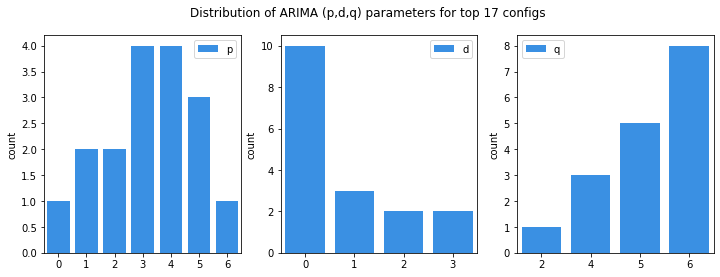

In [367]:
plot_pdq_distributions(metrics, num_top=len(metrics)//20 + 1)

Also, it looks like $p=3,4$ and $q=6$ are good choices. Of course, one should keep in mind these kind of plots don't take into account any correlation between the different hyperparameters, but just looks at the independently of on another. 

The above analysis says nothing about the absolute value of the performance metric. To get an idea of what how performance  changes with respect to changes in hyperparameter configuration, I plot the performance versus sorted MAE values:

In [368]:
def plot_metric_sorted(metrics, name='mae', num_plot=100):
    m = [(k, v[name]) for k, v in metrics.items()]
    m.sort(key=lambda kv: kv[1])
    configs, values= list(zip(*mae))

    fig, ax = plt.subplots(1)
    ax.plot(values[:num_plot], '-x', label=f'""{name} sorted by "{name}")')
    ax.legend()

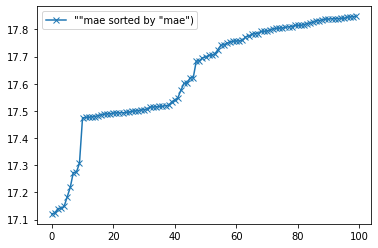

In [369]:
plot_metric_sorted(metrics)

It looks like there's a steep increase in MAE after the 10th best configuration (which is more like the  top 3%, not 5%):

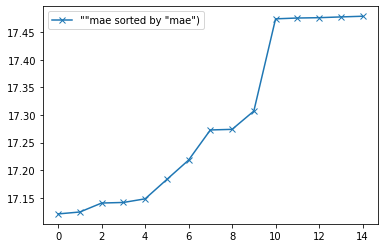

In [370]:
plot_metric_sorted(metrics, num_plot=15)

This means that the top 10 configurations form an elite "cluster" of sort, which likely share some common features. Since there are quite few data points to deal with we can just look at them:

In [373]:
name='mae'
mae = [(k, v[name]) for k, v in metrics.items()]
mae.sort(key=lambda kv: kv[1])
for i, (k, v) in enumerate(mae[:15]):
    print(f"{i}: {k}, {v}")

0: (3, 0, 5, 0, 0, 0, 0), 17.120758657342208
1: (3, 0, 6, 0, 0, 0, 0), 17.1242484011605
2: (5, 0, 6, 0, 0, 0, 0), 17.14048447820643
3: (2, 0, 4, 0, 0, 0, 0), 17.14152782921944
4: (2, 0, 6, 0, 0, 0, 0), 17.148095960757352
5: (4, 0, 5, 0, 0, 0, 0), 17.183277039876305
6: (4, 0, 6, 0, 0, 0, 0), 17.218339505123183
7: (6, 0, 5, 0, 0, 0, 0), 17.272911960347162
8: (4, 0, 4, 0, 0, 0, 0), 17.274025588334126
9: (5, 0, 4, 0, 0, 0, 0), 17.307147965560976
10: (4, 3, 6, 0, 0, 0, 0), 17.47429699758533
11: (3, 1, 5, 0, 0, 0, 0), 17.47578570018287
12: (5, 1, 6, 0, 0, 0, 0), 17.476401634827837
13: (0, 2, 6, 0, 0, 0, 0), 17.477764135893025
14: (3, 3, 5, 0, 0, 0, 0), 17.47900422585776


It's clear that relatatively large $p$ and $q$ value together with $d=0$ works best. Although this is a small number of configurations, we can look at the counts of the $p$, $d$, $q$ parameters, as before but now only for the top 10 configurations. With larger nubmer of configurations scanned, this kind of analysis will make even more sense.

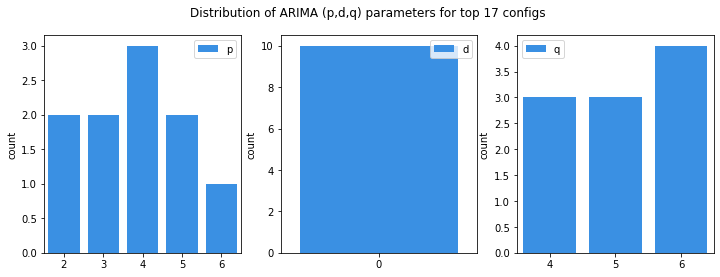

In [374]:
plot_pdq_distributions(metrics, num_top=10)

Based on this, $2\leq p \leq5$, $d=0$ and $4\leq q\leq6$ are all good choices. Also, from this we can infer that there is not very point in looking at larger $p$ and $q$ values for $d=0$.

## Result
In some cases, one might choose another configuration, for instance taking training time, model architecture or other metrics into account. 
In this case I just want a single configuration that works so I pick the best one,
$(p, d, q) = (3, 0, 5)$:

In [653]:
split = 16*period
order = (3, 0, 5)
trend = 'ct'

arima_config = dict(order=order, trend=trend)
print("ARIMA model orders", order)    
print(f"split: {split}, trend: {trend}")

# Train on `split` number of samples
model = ARIMA(df.sunspots[:split], **arima_config)
fit = model.fit()

# Validation MSE and MAE
# Predict on all, evaluate on non-training data
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), model, fit)

mae_base = evaluate(df.sunspots[split:], yhat[split:])['mae']
baseline_model = model
print(mae_base)

ARIMA model orders (3, 0, 5)
split: 2048, trend: ct


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17.120758657342208


As a sidenote, I tried also using the SARIMAX implementation from Statsmodels, which surprisingly gives somewhat different (worse) results:

In [656]:
# Train on `split` number of samples
model = SARIMAX(df.sunspots[:split], **arima_config)
fit = model.fit()

# Validation MSE and MAE
# Predict on all, evaluate on non-training data
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), model, fit)

print(evaluate(df.sunspots[split:], yhat[split:])['mae'])

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17.768469345479115


Since this is supposed to be the same model, there must be differences in the implementation (of the fitting). This gives an idea of the variation of this baseline itself.

To get a second reference point (baseline) also tried using this model but fit using another train/validation split, with more data for training:

In [661]:
split = 24*period

# Train on `split` number of samples
model = ARIMA(df.sunspots[:split], **arima_config)
fit = model.fit()

# Validation MSE and MAE
# Predict on all, evaluate on non-training data
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), model, fit)

mae_base_2 = evaluate(df.sunspots[split:], yhat[split:])['mae']
print(mae_base_2)

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10.851067691052291


We see that more training data leads to significantly lower validation MAE.

# MLP model
Now I want to see how a neural network models perform relative to my ARIMA baseline. I'll start with the simplest case, an MLP model.

In [33]:
# Based on: https://www.tensorflow.org/guide/data#time_series_windowing

def window_dataset(ds, window_size=5, shift=1, stride=1):
    """Return windowed dataset."""
    if not isinstance(ds, tf.data.Dataset) :
        ds = tf.data.Dataset.from_tensor_slices(ds)
    
    # Perform windowing. Result is nested, a dataset of "windows",
    # where each window is itself a dataset.
    windows = ds.window(window_size, shift=shift, stride=stride)

    # Transform window dataset into to batch datasets (with 1 sample)
    # and flatten results (concatenate batch datasets)
    def window_to_batch(window):
        # Make sure all windows are the same size by dropping remainder, if any.
        return window.batch(window_size, drop_remainder=True)

    windows = windows.flat_map(window_to_batch)

    return windows

In [9]:
def make_dataset(x, window_size=5, shuffle_buffer_size=None, batch_size=None):
    """Form input-to-output windows."""
    
    # Make windows of given size for predicting the value after the window (+1)
    # Elements: [x_i, ..., x_{i+w}]
    ds = window_dataset(x, window_size=window_size+1)

    # Map window of window_size-1 element (input) to last element (output)
    # Elements (tuple): ([x_i, ..., x_{i+w-1}], x_{i+w})
    #return ds.map(lambda z: z[-1])
    ds = ds.map(lambda z: (z[:-1], z[-1:]))
    
    # Shuffle and batch
    if shuffle_buffer_size:
        ds = ds.shuffle(shuffle_buffer_size)
    if batch_size:
        # Allow the last batch to be smaller
        ds = ds.batch(batch_size, drop_remainder=False)
    
    return ds

In [10]:
def mlp_model(input_shape, output_shape, num_nodes=10, activation='relu'):
    model = tf.keras.Sequential()
    
    #  Allow more general input shape
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    
    # Add layers with given number of nodes.
    # Nodes can be iterable or integer (single layer)
    if isinstance(num_nodes, int):
        num_nodes = [num_nodes]
    for num in num_nodes:
        model.add(tf.keras.layers.Dense(num, activation=activation))

    # Output layer (allow for more general output shape)
    num_out = 1
    for num in output_shape:
        if num:
            num_out *= num
    model.add(tf.keras.layers.Dense(num_out))
    model.add(tf.keras.layers.Reshape(output_shape))

    return model

In [41]:
def input_output_shapes(dataset):
    """Extract input and output shapes of a Tensorflow dataset."""
    return tuple((tuple((dim for dim in spec.shape if dim)) for spec in dataset.element_spec))

In [886]:
# Training and model config 

# for the dataset
shuffle_buffer_size = len(df)
batch_size = 32
split = period*16
window_size = 5

# for the model
num_nodes = [10, 10]
activation='relu'

# For `model.fit`
optimizer_cls = tf.keras.optimizers.Adam
optimizer_config = dict(lr=1e-8, beta_1=0.9)
metrics = ['mae', 'mse']
loss = tf.keras.losses.MeanSquaredError()
epochs = 100
callbacks = []

In [247]:
# Set numpy and tensorflow seeds and reset Tensorflow global state
# (https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session)
seed = 37
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
np.random.seed(seed)

In [248]:
ds_train = make_dataset(df.sunspots[:split], window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)
model = mlp_model(*input_output_shapes(ds), num_nodes=num_nodes, activation=activation)
model.summary()
model.compile(loss=loss, optimizer=optimizer_cls(**optimizer_config), metrics=metrics)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
reshape (Reshape)            (None, 1)                 0         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


## Dynamical learning rate tuning
The learning rate is known to be important so I'll tune that first by compiling the model to use a Tensorflow callback that gradually (every epoch) increases the learning rate during training. The learning rate that yields the smallest MSE should yield a decent tradeoff between taking fewer steps toward the minimum (large learning rate) and taking more accurate steps toward the minimum (small learning rate).

In [249]:
def learning_rate_at_epoch(epoch):
    return 1e-8 * 10**(epoch/20)

In [253]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_at_epoch)
callbacks = [lr_schedule]
optimizer = optimizer_cls(lr=learning_rate_at_epoch(0), beta_1=0.9)

model.compile(optimizer=optimizer, loss=loss)

In [254]:
history = model.fit(ds_train, epochs=200, callbacks=callbacks, verbose=0)

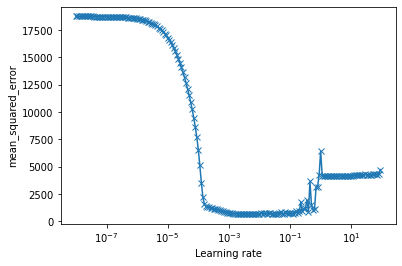

In [255]:
plt.semilogx(history.history['lr'], history.history['loss'], 'x-');
plt.xlabel('Learning rate')
plt.ylabel(f'{loss.name}');

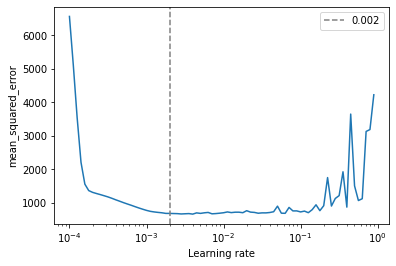

In [257]:
s = slice(80,-40)
plt.semilogx(history.history['lr'][s], history.history['loss'][s])
plt.xlabel('Learning rate')
plt.ylabel(f'{loss.name}')
lr_min = 2e-3
plt.axvline(lr_min, linestyle='--', color='grey', label=str(lr_min))
plt.legend();

Somewhere between $10^{-3}$ and $10^{-2}$ seems to be a good value. So I'll pick $2\cdot10^{-3}$.

In [887]:
optimizer_config['lr'] = 2e-3

## Training

In [752]:
def plot_metric(metric, start=None, end=None, skip=None, xlabel='epochs', ylabel='mae', linestyle='-', marker='x'):
    s = slice(start, end, skip)
    plt.plot(metric[s], linestyle=linestyle, marker=marker)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [1318]:
optimizer_config, optimizer

({'lr': 0.002, 'beta_1': 0.9},
 <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x17fb19490>)

In [277]:
# Set numpy and tensorflow seeds and reset Tensorflow global state
# (https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session)
seed = 37
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
np.random.seed(seed)

ds_train = make_dataset(df.sunspots[:split], window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)
model = mlp_model(*input_output_shapes(ds_train), num_nodes=num_nodes, activation=activation)
model.compile(loss=loss, optimizer=optimizer_cls(**optimizer_config), metrics=metrics)

In [278]:
history = model.fit(ds_train, epochs=100, callbacks=[], verbose=0)

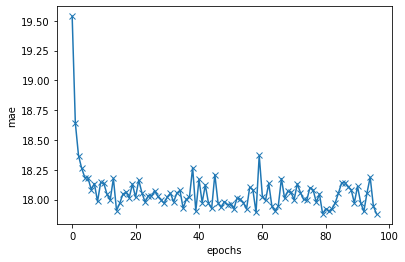

In [377]:
plot_metric(history.history['mae'], start=3)

## Predict/evaluate

In [527]:
def predict(y, model, in_sample=True):
    """Return predictions for y.
    
    This implementation will not do out-of-sample forecast (the next unseen time).
    """
    # Dataset for evaluating, windowed input for prediction
    window_size = model.input_shape[-1]
    ds_valid = make_dataset(y, window_size=window_size, batch_size=32)
    ds_x = ds_valid.map(lambda x, y: x)
    
    # Predictions, padded with zeroes 
    yhat = np.zeros(y.shape)
    yhat[window_size:] = model.predict(ds_x).ravel()
    
    end = None if in_sample else -1
    
    if isinstance(y, pd.Series):
        # Return same type as given
        yhat = pd.Series(yhat).reindex_like(df.sunspots)
        
    return yhat[:end]

In [528]:
yhat = predict(df.sunspots, model)

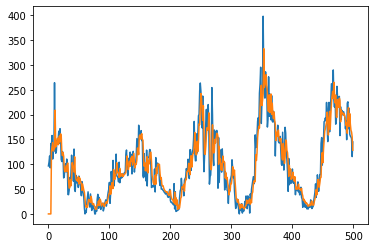

In [529]:
s = slice(0, 500)
plt.plot(df.sunspots[s] ,'-')
plt.plot(yhat[s], '-')

In [538]:
s = slice(split, None)
mae = evaluate(yhat[s], df.sunspots[s])['mae']
print(f"MAE = {mae} (baseline = {mae_base})")

MAE = 17.873312581045862 (baseline = 17.120758657342208)


## Training curves

In [979]:
def compile_and_train(y, window_size=5, split=2048, batch_size=32,
                      activation='relu', loss='mse', 
                      num_nodes=(10, 10), epochs=500):
    # Set numpy and tensorflow seeds and reset Tensorflow global state
    # (https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session)
    seed = 37
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

    ds_train = make_dataset(y[:split], window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)
    ds_valid = make_dataset(y[split:], window_size=window_size, batch_size=batch_size)
    
    model = mlp_model(*input_output_shapes(ds_train), num_nodes=num_nodes, activation=activation)
    model.compile(loss=loss, optimizer=optimizer_cls(**optimizer_config), metrics=metrics)
    
    history = model.fit(ds_train, validation_data=ds_valid, epochs=epochs, callbacks=[], verbose=0)
    
    return history, model

In [1054]:
def plot_training(history, metric, name="", skip=1):
    s = slice(0,-1, skip)
    epochs = range(len(history.history[metric]))[s]
    lines = plt.plot(epochs, history.history[metric][s], label=name)
    color = lines[0].get_color()
    plt.semilogx(epochs, history.history[f'val_{metric}'][s], label=f'{name} val', color=color, linestyle=':')
    plt.legend()

## Tune model complexity

The network size `num_nodes` and the size of the input to the network `window_size` will be important for whether the model is over- or underfitting. As a first exploration I scan a few combinations of these hyperparameters. I'll keep the ratio between the two constant (=4, here), since it's natural that a larger input feature space will require more parameters. I also try 1 or 2 hidden layers in  the network.

In [1086]:
sizes = [(1, (4)), # (window_size, num_nodes)
         (5, (20)),
         (25, (100)),
         (1, (4, 4)),
         (5, (20, 20)),
         (25, (100, 100)),
        ]

In [1088]:
histories_sizes = dict()
for s in sizes:
    window_size, num_nodes = s
    print(window_size, num_nodes)
    history, _ = compile_and_train(df.sunspots, window_size=window_size, num_nodes=num_nodes, batch_size=200, epochs=1000)
    histories_sizes[s] = history

1 4
5 20
25 100
1 (4, 4)
5 (20, 20)
25 (100, 100)


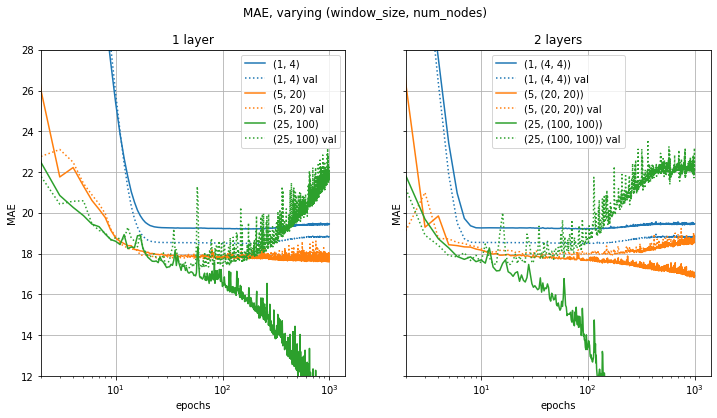

In [1144]:
fig, axes = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 6))
plt.sca(axes[0])
plt.suptitle("MAE, varying (window_size, num_nodes)");


for i, s in enumerate(sizes):
    # Configure axis
    window_size, num_nodes = s 
    if isinstance(num_nodes, int) or len(num_nodes)== 1:
        plt.sca(axes[0])
        plt.title("1 layer")
    else:
        plt.sca(axes[1])
        plt.title("2 layers")

    v = histories_sizes[s]

    plot_training(v, 'mae', f"{s}", skip=1)
for ax in axes:
    plt.sca(ax)
    plt.grid()
    plt.xlabel("epochs")
    plt.ylabel("MAE")
    plt.xlim(2, max(plt.xlim()))
    plt.ylim(12, 28)


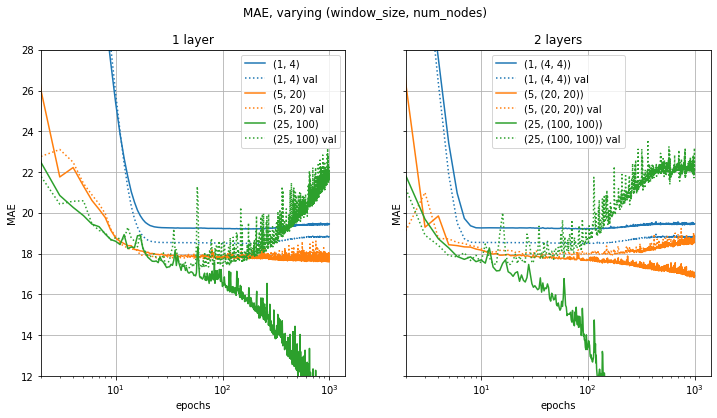

In [1445]:
fig, axes = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 6))
plt.sca(axes[0])
plt.suptitle("MAE, varying (window_size, num_nodes)");


for i, s in enumerate(sizes):
    # Configure axis
    window_size, num_nodes = s 
    if isinstance(num_nodes, int) or len(num_nodes)== 1:
        plt.sca(axes[0])
        plt.title("1 layer")
    else:
        plt.sca(axes[1])
        plt.title("2 layers")

    v = histories_sizes[s]

    plot_training(v, 'mae', f"{s}", skip=1)
for ax in axes:
    plt.sca(ax)
    plt.grid()
    plt.xlabel("epochs")
    plt.ylabel("MAE")
    plt.xlim(2, max(plt.xlim()))
    plt.ylim(12, 28)


Above are the training curves, with 1-layer models to the left and 2-layer models to the right. The validation error (dotted) is what we care about for performance. We see that for more complex models (increasing window size and number of nodes), the validation MAE starts increasing at some point, while the training MAE keeps decreaing. This is a sign of overfitting. We see that this effect is amplified when adding a second layer to the model (right). From these results it's clear that the simplest models (width 4) are inferior (high bias) to the medium-sized model (width 20). There appears to be a potential for the largest model (width 100) to perform the best since the minimum validation error is obtained by this model, given that the model can be regularized, preventing overfitting.  However, I don't expect the advantage to be particularly large. Possibly, the dataset is simply to small or simple for a larger model to be useful here.

## Regularization
Here I investigate whether regularization can help  the (25, (100,100))-sized network compete with the simpler (5, 20) network. I focus on the 2-layer network hoping to see more effect of regularization. I look into both L2 weight-regularization and drop-out regularization.

**L2-regularization** modifies training by adding a L2-norm penalty to the loss function so that large weights (a characteristic of overfitting) are penalized:

\begin{equation}
\mathcal{L}' = \mathcal{L} + \lambda \sum_i \theta_i^2,
\end{equation}
where $\theta_i$ are the model weights (of a layer) and $\lambda$ is the L2-regularization strength. This is a form of *weight regularization*.

With **dropout**, we rather modify the architecture of the model by adding a drop-out layer that randomly sets a certain fraction of values in the output vector of a layer to zero. The effect is to separate contributions from individual node, since they can't "rely" on the other nodes being non-zero. 

L2 regularizaiont strength ($\lambda$) needs to be tuned scale of the loss function, which depends on the data normalization. The dropout fraction on the other hand needs to be tuned to the network architecture, the number of nodes in a layer. Or the other way around, a network with dropout layers need to be sufficiently large to support dropout.


A combination of dropout and weight regularization may also be effective since they work in different and possible complementary ways. Dropout regularization may still get issues with large weights, which a combined approach can alleviate.

Other regularization techniques which I don't consider here:
- L1 regularization: weight regularization with penalty $\lambda \sum_i |\theta_i|$
- Elastic net regularization, a combination of L1 and L2: $\lambda_1 \sum_i |\theta_i| + \lambda_2 \sum_i |\theta_i|^2 $
- Max (L2) norm constraints: $\sum_i |\theta_i|^2 < c$.

I define a regularized-equipped model for this purpose:

In [1150]:
def mlp_model_regularized(input_shape, output_shape, num_nodes=10, activation='relu',
              dropout=None, l2_regularization=None):
    model = tf.keras.Sequential()
    
    #  Allow more general input shape
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    
    # Add layers with given number of nodes.
    # Nodes can be iterable or integer (single layer)
    if isinstance(num_nodes, int):
        num_nodes = [num_nodes]
    if l2_regularization:
        l2 = tf.keras.regularizers.l2(l2_regularization)
    else:
        l2 = None
    for num in num_nodes:
        model.add(tf.keras.layers.Dense(num, activation=activation, kernel_regularizer=l2))
        if dropout:
            model.add(tf.keras.layers.Dropout(dropout))

    # Output layer (allow for more general output shape)
    num_out = 1
    for num in output_shape:
        if num:
            num_out *= num
    model.add(tf.keras.layers.Dense(num_out))
    model.add(tf.keras.layers.Reshape(output_shape))

    return model

In [1502]:
def compile_and_train_regularized(y, window_size=5, split=2048, batch_size=32,
                                  activation='relu', loss='mse', 
                                  num_nodes=(10, 10), epochs=500,
                                  dropout=None, l2_regularization=None,
                                  verbose=0):
    # Set numpy and tensorflow seeds and reset Tensorflow global state
    # (https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session)
    seed = 37
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

    ds_train = make_dataset(y[:split], window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)
    ds_valid = make_dataset(y[split:], window_size=window_size, batch_size=batch_size)
    
    model = mlp_model_regularized(
        *input_output_shapes(ds_train), num_nodes=num_nodes, activation=activation,
        dropout=dropout, l2_regularization=l2_regularization)
    model.compile(loss=loss, optimizer=optimizer_cls(**optimizer_config), metrics=metrics)
    
    history = model.fit(ds_train, validation_data=ds_valid, epochs=epochs, callbacks=[], verbose=verbose)
    
    return history

### L2 regularization

Then I scan different values of the L2 regularization strength. Since I'm using the raw data (no normalization) the values relevant values for the regularization strength $\lambda$ will relate to the overall scale of the data, which is on the order of 100.

In [1534]:
window_size, num_nodes = 25, (100, 100)
l2_regularizations = [0, 1, 10, 100, 1000]

In [1225]:
histories_l2lambda = dict()
for l2 in l2_regularizations:
    print(l2)
    history = compile_and_train_regularized(df.sunspots, window_size=window_size, num_nodes=num_nodes, batch_size=200, epochs=1000,
                                              l2_regularization=l2, dropout=None)
    histories_l2lambda[l2] = history

1
10
100
1000


Baseline mean and standard deviation of MAE (last 50 epochs): 17.86647773742676 0.07921422024795415


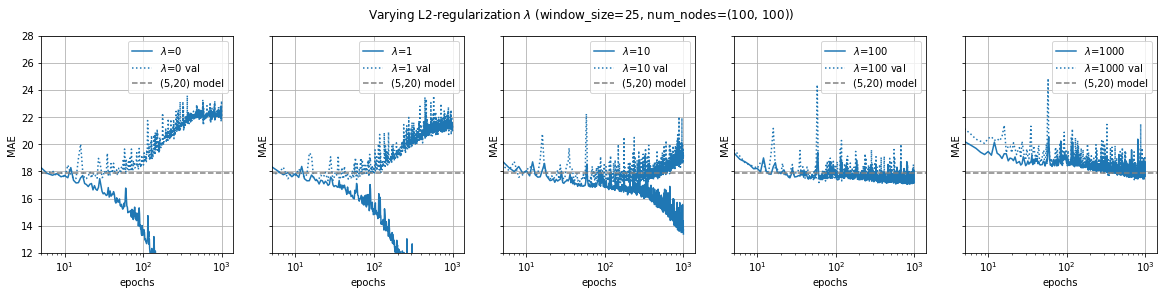

In [1538]:
# A baseline from 50 last epochs of simple model
tail = histories_sizes[(5,20)].history['val_mae'][-50:]
base_mean, base_std = np.mean(tail), np.std(tail)
print("Baseline mean and standard deviation of MAE (last 50 epochs):", base_mean, base_std)

figsize=4
num_rows = 1
num_cols = len(l2_regularizations)
fig, axes = plt.subplots(num_rows, num_cols, sharey=True, figsize=(num_cols*figsize, num_rows*figsize))
axes = axes.ravel()

plt.suptitle(f"Varying L2-regularization $\lambda$ (window_size={window_size}, num_nodes={num_nodes})");

for i, k in enumerate(l2_regularizations):
    v = histories_l2lambda[k]
    ax = axes[i]
    plt.sca(ax)
    plot_training(v, 'mae', f"$\lambda$={k}", skip=1)

for ax in axes:
    plt.sca(ax)
    plt.grid()
    plt.xlabel("epochs")
    plt.ylabel("MAE")
    plt.xlim(5, max(plt.xlim()))
    plt.ylim(12, 28)
    plt.axhline(base_mean, color='gray', linestyle='--', label='(5,20) model')
    plt.legend()

Above we see the effect of applying different L2 regularization strengths, increasing from left to right. In the figure we also see the baseline value from the simpler model (`window_size`, `num_nodes`) = (5, 20). We see that the gap between validation and training error diminishes with larger $\lambda$, but for very large values ($\lambda \ge 1000$) the overall error increases because of the large penalty. Based on this $10<\lambda<100$ are good values.

### Dropout regularization
The hyperparameter for dropout regularization is the dropout rate, the fraction of the number of nodes in each layer that will randomly be zeroed. To see the effect of different dropout rates. A rule of thumb is that a dropout rate of $d$ corresponds to using an ensemble of networks $1-d$ wide (the retain rate). E.g.  $\text{dropout} = 0.8$ applied to a 100 node wide layer $\leftrightarrow$ an ensemble of layers $20$ nodes wide. Also, I note because of the noise that dropout adds, training time is expected to increase.

In [1544]:
window_size, num_nodes = 25, (100, 100)
dropout_rates = [0, 0.2, 0.4, 0.6, 0.8]

In [1546]:
histories_dropout = dict()
for v in dropout_rates:
    print(v)
    history = compile_and_train_regularized(df.sunspots, window_size=window_size, num_nodes=num_nodes, batch_size=200, epochs=1000,
                                              l2_regularization=None, dropout=v)
    histories_dropout[v] = history

0
0.2
0.4
0.6
0.8


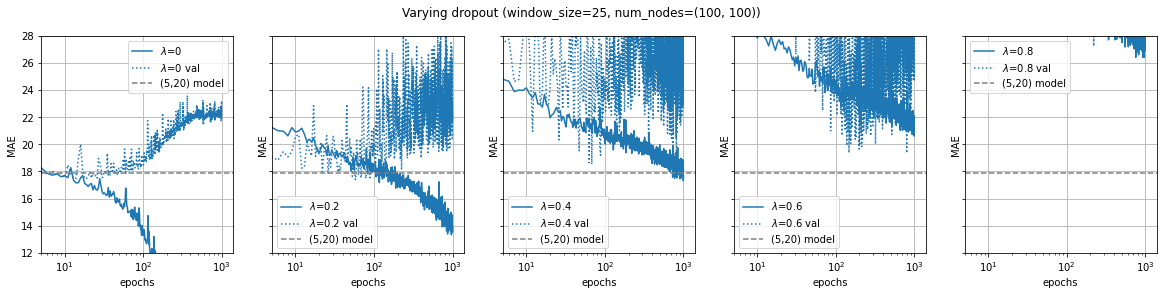

In [1547]:
figsize=4
num_rows = 1
num_cols = len(dropout_rates)
fig, axes = plt.subplots(num_rows, num_cols, sharey=True, figsize=(num_cols*figsize, num_rows*figsize))
axes = axes.ravel()

plt.suptitle(f"Varying dropout (window_size={window_size}, num_nodes={num_nodes})");

for i, k in enumerate(dropout_rates):
    v = histories_dropout[k]
    ax = axes[i]
    plt.sca(ax)
    plot_training(v, 'mae', f"$\lambda$={k}", skip=1)

for ax in axes:
    plt.sca(ax)
    plt.grid()
    plt.xlabel("epochs")
    plt.ylabel("MAE")
    plt.xlim(5, max(plt.xlim()))
    plt.ylim(12, 28)
    plt.axhline(base_mean, color='gray', linestyle='--', label='(5,20) model')
    plt.legend()

Wow, that looks like dropout didn't help much straight off the bat. As a final test I'll try a combination of dropout and L2.

### Dropout + L2

In [1554]:
window_size, num_nodes = 25, (100, 100)
dropout_rates = [0.1, 0.2]
l2s = [10, 100]

In [1555]:
histories_l2_dropout = dict()
for l2 in l2s:
    for d in dropout_rates:
        print(l2, d)
        history = compile_and_train_regularized(df.sunspots, window_size=window_size, num_nodes=num_nodes, batch_size=200, epochs=1000,
                                                  l2_regularization=l2, dropout=d)
        histories_l2_dropout[(l2, d)] = history

10 0.1
10 0.2
100 0.1
100 0.2


In [1567]:
histories_l2_dropout

{(10, 0.1): <tensorflow.python.keras.callbacks.History at 0x191c95460>,
 (10, 0.2): <tensorflow.python.keras.callbacks.History at 0x180015190>,
 (100, 0.1): <tensorflow.python.keras.callbacks.History at 0x18f3448b0>,
 (100, 0.2): <tensorflow.python.keras.callbacks.History at 0x192a219a0>}

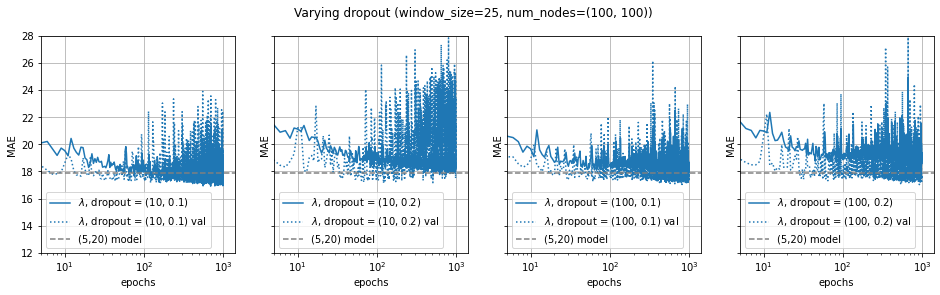

In [1569]:
figsize=4
num_rows = 1
num_cols = len(histories_l2_dropout)
fig, axes = plt.subplots(num_rows, num_cols, sharey=True, figsize=(num_cols*figsize, num_rows*figsize))
axes = axes.ravel()

plt.suptitle(f"Varying dropout (window_size={window_size}, num_nodes={num_nodes})");

for i, k in enumerate(histories_l2_dropout.keys()):
    v = histories_l2_dropout[k]
    ax = axes[i]
    plt.sca(ax)
    plot_training(v, 'mae', f"$\lambda$, dropout = {k}", skip=1)

for ax in axes:
    plt.sca(ax)
    plt.grid()
    plt.xlabel("epochs")
    plt.ylabel("MAE")
    plt.xlim(5, max(plt.xlim()))
    plt.ylim(12, 28)
    plt.axhline(base_mean, color='gray', linestyle='--', label='(5,20) model')
    plt.legend()

Adding the extra L2 regularization did indeed help "regularizing" dropout. However, from the training curves it looks like dropout does not offer an advantage in training. After some tens of epochs, training is mostly dominated by noise. Perhaps the model is not large enough for it to make sense. 

# Conclusions
It turned out to require a lot of work to improve over as simple model using regularization. The best MLP model candidates based on the above hyperparameter search are
- (`window_size`, `num_nodes`) = (25, (100, 100)) L2-regularized with $\lambda=100$
- (`window_size`, `num_nodes`) = (5, 20), no regularization

The ARIMA(3, 0, 5) model was very competitive, but as can be seen below the result depends on whether the ARIMA or statsmodels ARIMA or SARIMAX implementation was used.

In this case, I'd choose the (25, (100, 100)) MLP since it is still relatively simple and allows also for more flexibility in extending further.

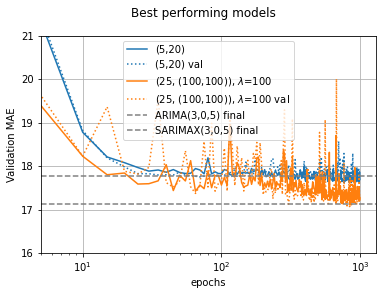

In [1646]:
fig, ax = plt.subplots(1,1)

plt.suptitle(f"Best performing models");

skip = 5
plot_training(histories_sizes[(5,20)], 'mae', f"(5,20)", skip=5)
plot_training(histories_l2lambda[100], 'mae', f"(25, (100,100)), $\lambda$=100", skip=5)

plt.axhline(mae_base, color='gray', label='ARIMA(3,0,5) final', linestyle='--')
plt.axhline(17.76846, color='gray', label='SARIMAX(3,0,5) final', linestyle='--')

plt.grid()
plt.xlabel("epochs")
plt.ylabel("Validation MAE")
plt.xlim(5, max(plt.xlim()))
plt.ylim(16, 21)
plt.legend();

# What next?
Here, I've done a grid search on the learning rate, parameters affecting model size, as well as on regularization variants. If I'd like to investigate further, the following hyperparameters/factors can be important:

- Normalization: min-max scaling, standardization
- Loss function: Huber loss
- Activation function: (Elu, ReLu, tanh)
- Batch size: the number of samples per weight update
- Learning rate schedule (inverse-time decay) 

However, what may be most useful is to look into **feature engineering** and  different **model architechtures**  more suitable for timeseries than a simple densely connected MLP, such as RNNs, LSTMs. Also, addding convolutional to the front of the network may help define better features for the data. For instance, 
[this blog post](https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57)
provides an overview of more advanced ways to automate feature engineering of time-series using convolutional layers. As mentioned there, down-sampling and smoothing transformations are generally useful for building meaningful representations of the timeseries.